<a href="https://colab.research.google.com/github/kmayutrisna/IMDB/blob/main/IMDB_word2vec%2BbiGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary library
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, GRU

In [2]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Display top of data
data =pd.read_csv("drive/My Drive/data/IMDB Dataset.csv")

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Text preprocessing
from nltk.corpus import stopwords
def preprocess_text(text):

    # Text cleaning
    text = re.sub('[^a-zA-Z]', ' ', text)

    #Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    #Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Lowercasing
    text = text.lower()

    # Lowercasing
    text = text.split()

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]

    # Join the tokens back to a single string
    text = ' '.join(text)
    return text

In [6]:
# Preprocess the text column
data['review'] = data['review'].apply(preprocess_text)

In [7]:
# Preprocess the text data
texts = data['review'].values
labels = data['sentiment'].map({'positive': 1, 'negative': 0}).values

In [8]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [9]:
# Tokenize the text data
num_words = 10000
max_sequence_length = 300

tokenizer = Tokenizer(num_words=num_words)  # You can adjust 'num_words' based on your vocabulary size
tokenizer.fit_on_texts(train_data)

# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

  # You can adjust this based on your dataset
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

In [10]:
# Load Word2Vec Embeddings
embedding_dim = 300
from gensim.models import KeyedVectors

word2vec_model_path = 'drive/My Drive/data/GoogleNews-vectors-negative300.bin'

word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

#word2vec_model = Word2Vec.load(word2vec_model_path)
word_index = tokenizer.word_index

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i < num_words and word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

In [11]:
# Build CNN Model
model = keras.Sequential([
    Embedding(num_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False),
    # Add a single LSTM layer
    Bidirectional(GRU(64)),  # You can adjust the number of units as needed
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Train the Model
epochs = 5
batch_size = 128

history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 269s 1s/step - loss: 0.4642 - accuracy: 0.7804 - val_loss: 0.3812 - val_accuracy: 0.8359
Epoch 2/5
250/250 [==============================] - 263s 1s/step - loss: 0.3327 - accuracy: 0.8631 - val_loss: 0.3075 - val_accuracy: 0.8789
Epoch 3/5
250/250 [==============================] - 250s 1s/step - loss: 0.2998 - accuracy: 0.8786 - val_loss: 0.2898 - val_accuracy: 0.8861
Epoch 4/5
250/250 [==============================] - 265s 1s/step - loss: 0.2795 - accuracy: 0.8867 - val_loss: 0.2878 - val_accuracy: 0.8864
Epoch 5/5
250/250 [==============================] - 262s 1s/step - loss: 0.2715 - accuracy: 0.8907 - val_loss: 0.2777 - val_accuracy: 0.8900


In [13]:
# Assuming you already have predictions and test_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

predictions = model.predict(test_sequences)
predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_labels, predictions)
print(f"MCC Score: {mcc * 100:.2f}%")

313/313 [==============================] - 51s 159ms/step
Accuracy: 88.15%
Precision: 87.90%
Recall: 88.69%
F1 Score: 88.29%
MCC Score: 76.30%


In [14]:
# Calculate and print classification report
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(test_labels, predictions, target_names=['Negative', 'Positive'])
print("Classification Report:\n", report)

# Calculate and print confusion matrix
confusion = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n", confusion)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      4961
    Positive       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Confusion Matrix:
 [[4346  615]
 [ 570 4469]]


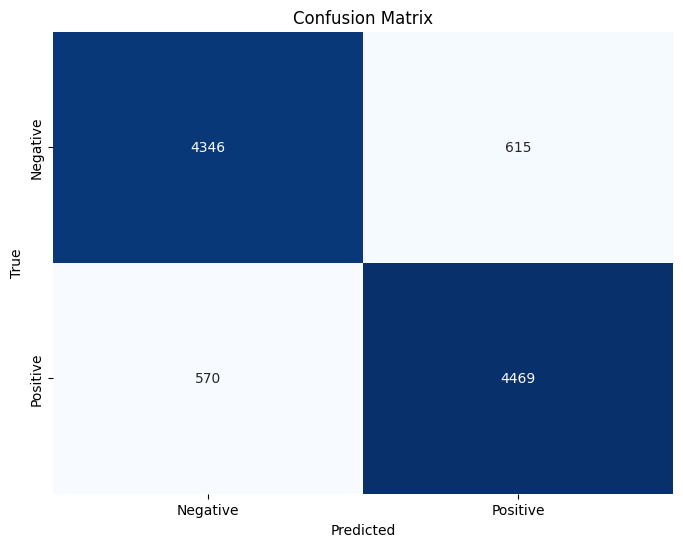

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion = confusion_matrix(test_labels, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

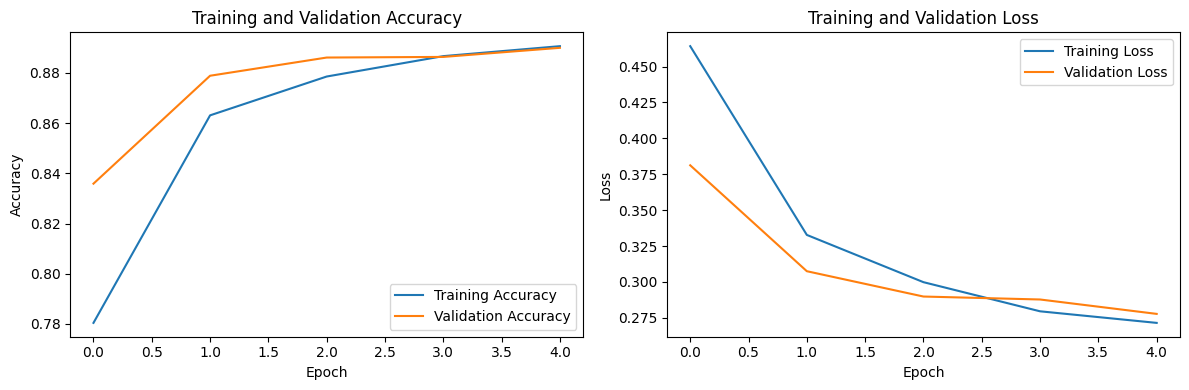

In [16]:
# Plot Training History (Accuracy and Loss)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
